# Analyse van een exponentieel verval

In [1]:
import pandas as pd
import numpy as np
from lmfit import models

## Importeren en bekijken van de data

We importeren de dataset en kijken even of dat goed ging.

In [2]:
data = pd.read_csv('verval.txt')

In [3]:
data.head()

,tijd,counts
0,0,1265
1,1,688
2,2,410
3,3,241
4,4,132


We zien een kolom **tijd** en een kolom **counts**, met negen meetpunten. De fouten op de meetpunten stonden niet in het bestand, maar wel in de opgave. De fout op het aantal counts $N$ wordt gegeven door $\sqrt N$. We maken een nieuwe kolom `yerr` als volgt:

In [4]:
data['yerr'] = np.sqrt(data.counts)

Merk op dat we de data nu kunnen bekijken door zowel `data['yerr']` als `data.yerr` te typen, maar dat we nieuwe kolommen alléén kunnen maken met de `data['yerr']`-notatie. We inspecteren even de eerste vijf regels om te zien of alles goed ging:

In [5]:
data.head()

,tijd,counts,yerr
0,0,1265,35.566838
1,1,688,26.229754
2,2,410,20.248457
3,3,241,15.524175
4,4,132,11.489125


We maken een plot van counts tegen tijd, met de juiste foutvlaggen:

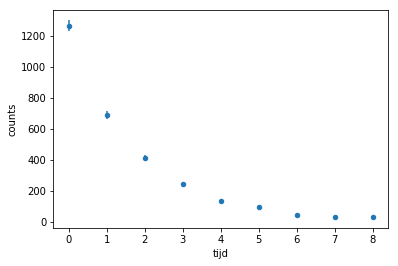

In [6]:
data.plot.scatter('tijd', 'counts', yerr='yerr')

Er lijkt een constante achtergrond over te blijven; het aantal vervallen per seconde gaat niet naar nul:

In [7]:
data.tail()

,tijd,counts,yerr
4,4,132,11.489125
5,5,93,9.643651
6,6,41,6.403124
7,7,29,5.385165
8,8,30,5.477226


## Fitten aan exponentiële functie plus constante achtergrond

### Gebruik maken van ingebouwde modellen

We kunnen met `lmfit` eenvoudig modellen optellen:

In [8]:
model = models.ExponentialModel() + models.ConstantModel()

Vervolgens fitten we dit model aan de data en bekijken het resultaat. Merk op dat de *gewichten* van de datapunten de inverse zijn van de *fouten* op de datapunten (hoe kleiner de onzekerheid, hoe groter het gewicht):

In [9]:
fit = model.fit(data.counts, x=data.tijd, weights=1 / data.yerr)

Een rapport van de uitkomst van de fit krijgen we als volgt:

In [10]:
print(fit.fit_report())

[[Model]]
    (Model(exponential) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 9
    # variables        = 3
    chi-square         = 7.00035413
    reduced chi-square = 1.16672569
    Akaike info crit   = 3.73862544
    Bayesian info crit = 4.33029918
[[Variables]]
    decay:      1.73323436 +/- 0.06537102 (3.77%) (init = 1)
    amplitude:  1244.05587 +/- 33.0431890 (2.66%) (init = 1)
    c:          11.1130703 +/- 5.38179988 (48.43%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, c)         = -0.767
    C(decay, amplitude) = -0.513
    C(amplitude, c)     =  0.159



Hier vind je de $\chi_\mathrm{red}^2$, die mooi rond de 1 ligt, en ook de waardes van de fitparameters. Zo blijkt de constante achtergrond $c$ slechts 11 counts te zijn en de vervalconstante $\tau = 1.73(7)$ min.

Het is altijd fijn om even visueel in te schatten hoe de fit eruit ziet. Dat gaat makkelijk met `fit.plot()`, waarbij je de parameter `numpoints` kunt gebruiken om op te geven dat de fitlijn met meer punten geplot moet worden dan slechts het aantal datapunten.

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.gridspec.GridSpec at 0x1178b4c50>)

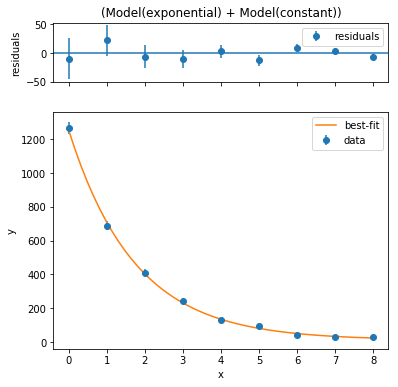

In [11]:
fit.plot(numpoints=50)

### Gebruik maken van handmatig gedefinieerde functies

Het is ook mogelijk om zelf fitfuncties te definiëren, en dat gaat het makkelijkst met `lambda`-functies. Dit kan van pas komen wanneer we een model willen fitten dat niet ingebouw is, of waarvan de vorm ons niet helemaal aanstaat. Als voorbeeld definiëren we:
$$
f(t) = N_0 e^{-t/\tau} + C
$$

In [12]:
f = lambda t, N0, tau, C: N0 * np.exp(-t / tau) + C

Wanneer we nu ons model maken, zullen we zelf eerste schattingen van de parameters moeten geven. Dit kan zeker van pas komen wanneer een fit lastig is, en de computer een beetje moet worden geholpen. Voor nu zetten we de parameters allemaal op 1, en zien we wel waar het schip strand.

In [13]:
model = models.Model(f)
params = model.make_params(N0=1, tau=1, C=1)

Het enige verschil met de aanroep van `fit()` hierboven is dat we nu de parameters meegeven via de `params` variabele.

In [14]:
fit = model.fit(data.counts, t=data.tijd, weights=1 / data.yerr, params=params)

En vervolgens zien we dat we dezelfde uitkomst hebben gevonden.

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.gridspec.GridSpec at 0x1179e3828>)

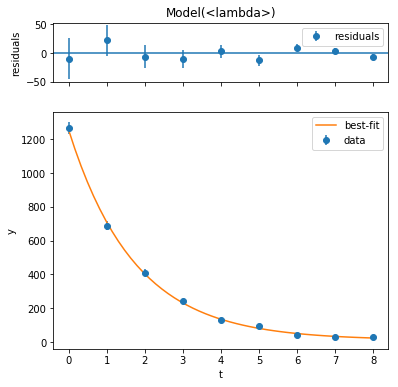

In [15]:
fit.plot(numpoints=50)

In [16]:
print(fit.fit_report())

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 9
    # variables        = 3
    chi-square         = 7.00035413
    reduced chi-square = 1.16672569
    Akaike info crit   = 3.73862544
    Bayesian info crit = 4.33029918
[[Variables]]
    N0:   1244.05586 +/- 33.0432053 (2.66%) (init = 1)
    tau:  1.73323438 +/- 0.06537089 (3.77%) (init = 1)
    C:    11.1130694 +/- 5.38178919 (48.43%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau, C)  = -0.767
    C(N0, tau) = -0.513
    C(N0, C)   =  0.159

